<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Web APIs & NLP

# 06_Model Evaluation, Findings & Recommendations

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

import re
import string
import nltk
stopwords = nltk.corpus.stopwords.words("english")
wn = nltk.WordNetLemmatizer()

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

## Model Selection

## Recap: Model Scores




LogReg x Count             |  LogReg x Tf-idf
:-------------------------:|:-------------------------:
<img src="../image/count_cm.png" style="width:40em" /> | <img src="../image/tfidf-cm.png" style="width:40em" />

### Based on above, the logistic regression model with tf-idf vectorization yields better results as: 

- It has a higher recall score (0.964, compared to 0.959) and fewer false negatives (18, compared to 21)
- While the accuracy score of the `LogReg x Count` model is higher, its cross validation (CV) score is lower. This suggests that the accuracy score will be higher on average if we go with the `LogReg x Tf-idf model`.

### Given these, we proceed with the `LogReg x Tf-idf` model.

## Model Hyperparameter Tuning 
Now that we have chosen the model and the vectorization method, we can proceed to tune the hyperparameters for even better model performance.

### Import Data 

In [2]:
data_1 = pd.read_csv("../data/vectorized/tfidf.csv")

In [3]:
# create dataframe with only relevant columns for modelling
data = data_1[["subreddit_class", "text"]]
data.head()

,subreddit_class,text
0,stocks,Advise on Long Term Stock? I am earning very l...
1,stocks,Dad told me to sell on Monday when the market ...
2,stocks,Merger/accusation question about a game co. An...
3,stocks,Best Software to Track Trades and Create Repor...
4,stocks,"After Driving My Friends Tesla, Here Are My Th..."


### Pre-processing: Dummification of target variable 

In [4]:
# dummify target variable: 1 = stocks, 0 = cryptocurrency
dummify = {"stocks":1, "CryptoCurrency":0}
data["subreddit_class"] = data["subreddit_class"].map(dummify);
data["subreddit_class"].value_counts()

<ipython-input-4-93913a3f4e9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["subreddit_class"] = data["subreddit_class"].map(dummify);


0    1700
1    1700
Name: subreddit_class, dtype: int64

### Setting up the IVs and DV for modelling

In [5]:
# we exclude the hours_dummy feature from our model as we do not want to vectorise these fields 
X = data["text"]
y = data["subreddit_class"]
print(X.shape)
print(y.shape)

(3400,)
(3400,)


### Train-Test Split

In [6]:
# shuffle dataset, set test size as 30% per industry norm
# stratify the train-test split based on target variable
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y, random_state=42)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2380,)
(2380,)
(1020,)
(1020,)


### Pre-processing: Clean, remove punctuations/stopwords, tokenize and lemmatize 

In [8]:
# define function to clean the original text 
def clean_text(text):
    
    # remove unicode characters 
    text = text.encode('ascii', 'ignore').decode()
    
    # remove references to subreddits, e.g. "r/"WallStreetBets, numbers and http links
    text= re.sub(r"r/", "", text)
    text = re.sub(r"\w*\d+\w*", "", text)
    text= re.sub(r"http\S+", "", text)

    # remove punctuations, tokenize, remove stopwords and lemmatize 
    ## we use lemmatization instead of stemming as it tends to be more accurate
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text) 
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]

    return text

### Hyperparameter Tuning using GridSearchCV

In [9]:
# set a pipeline up with two stages:
# 1. Tf-idfVectorizer (transformer)
# 2. Logistic Regression (estimator)

pipe = Pipeline([
    ('tf_idf', TfidfVectorizer(analyzer=clean_text)),
    ('logreg', LogisticRegression(max_iter=10_000))
])

In [10]:
# use GridCV to search over the following values of hyperparameters:
# Maximum number of features fit: 4000, 5000, 6_000
# Minimum number of documents needed to include token: 1, 2, 3
# Maximum number of documents needed to include token: 70%, 75%, 80%, 85%, 90%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'tf_idf__max_features': [4_000, 5_000, 6_000],
    'tf_idf__min_df': [1, 2, 3],
    'tf_idf__max_df': [.7, .75, .8, .85,.9, .95],
}

# Instantiate GridSearchCV.
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5) # 5-fold cross-validation.

In [11]:
# fit GridSearch to training data
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf_idf',
                                        TfidfVectorizer(analyzer=<function clean_text at 0x000001D42C7D00D0>)),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'tf_idf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                         'tf_idf__max_features': [4000, 5000, 6000],
                         'tf_idf__min_df': [1, 2, 3]})

In [12]:
# mean cross-validated score of the best_estimator
print("mean cv score of the best estimator: ", gs.best_score_) 

# score model on training set
print("accuracy score on train set: ", gs.score(X_train, y_train))

# score model on testing set
print("accuracy score on test set: ", gs.score(X_test, y_test))

mean cv score of the best estimator:  0.9634453781512604
accuracy score on train set:  0.9882352941176471
accuracy score on test set:  0.961764705882353


In [13]:
# find out what's the best parameters for tf-idf vectorization
gs.best_params_

{'tf_idf__max_df': 0.7, 'tf_idf__max_features': 5000, 'tf_idf__min_df': 3}

### Model fitting on the best parameters for vectorization

In [14]:
# instantiate a TF-IDFVectorizer, include clean_text function as the analyzer
# apply optimal settings based on GridSearchCV
tfidf_vect = TfidfVectorizer(analyzer=clean_text, min_df=3, max_df=0.7, max_features=5_000)
X_tfidf = tfidf_vect.fit_transform(data['text'])

In [15]:
# we expand sparse matrix out to a collection of arrays and store it in a data frame
tfidf_df = pd.DataFrame(X_tfidf.toarray())
tfidf_df.columns = tfidf_vect.get_feature_names()
tfidf_df.head()

,,aaii,aapl,aave,abandoned,abc,ability,able,aboard,abroad,...,ytd,yuan,yup,z,zacks,zealand,zen,zero,zoom,zscaler
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.482017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# setting up the IVs and DV for modelling
X = tfidf_df
y = data["subreddit_class"]
print(X.shape)
print(y.shape)

(3400, 5000)
(3400,)


In [17]:
# shuffle dataset, set test size as 30% per industry norm
# stratify the train-test split based on target variable 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y, random_state=42)

In [18]:
# fit the model based on train data
# set hyperparameters for LogisticRegression 
# apply l1 penalty as it produces better scores than l2 penalty 
# use liblinear solver (good for small dataset)

logreg = LogisticRegression(max_iter=10_000, penalty='l1', solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)
print(logreg)
print("-"*50)

# predicts y values using LogisticRegression & print accuracy score
y_pred = logreg.predict(X_test)
print("train accuracy score: ", logreg.score(X_train, y_train))
print("test accuracy score: ", accuracy_score(y_test, y_pred))
print("recall/sensitivity score: ",  recall_score(y_test, y_pred))

LogisticRegression(max_iter=10000, penalty='l1', random_state=42,
                   solver='liblinear')
--------------------------------------------------
train accuracy score:  0.9525210084033613
test accuracy score:  0.95
recall/sensitivity score:  0.9803921568627451


## Model Evaluation

### The model performance is strong with 95% accuracy score (higher than 50% for the baseline model) and a relatively high recall or sensitive score of 98%.

- 95% accuracy score: This means out of 100 subreddit posts, the model makes an accurate prediction for 95 posts. 
- 98% sensitivity score: This means that when the model is given 100 r/stocks subreddits, it is able to correctly label 98 posts as belonging to r/stocks (i.e. low classification error for posts that truly belong to the subreddit of interest).

In [19]:
# generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       510
           1       0.92      0.98      0.95       510

    accuracy                           0.95      1020
   macro avg       0.95      0.95      0.95      1020
weighted avg       0.95      0.95      0.95      1020



#### Recap on Classification Metrics Formula
* Accuracy = True Predictions / Total Predictions
* Precision = True Positives / (True Positives + False Positives)
* Recall = True Positives / (True Positives + False Negatives)
* F1-Score  = Weighted Average of Precision and Recall
    * Offers a better overall measure of performance
* Support = True Positives (or True Negatives) that lie in that class

### The confusion matrix below provides a more granular visualization of the model outcome:
Out of 1,020 observations (i.e. subreddit posts), the model yielded:
- 469 True Negatives (actual Crypto posts labelled (or predicted) under r/CryptoCurrency)
- 41 False Negatives (actual Crypto posts labelled under r/stocks)
- 500 True Positives (actual stocks posts labelled under r/stocks)
- 10 False Positives (actual stocks posts labelled under r/CryptoCurrency)

This is encouraging as the number of false positives is relatively low (~2% chance of misclassification).

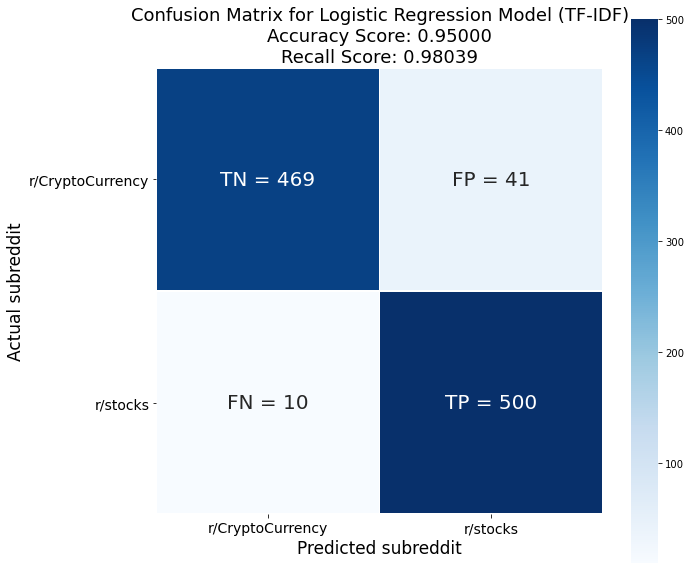

In [20]:
# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# create modified labels for confusion matrix
modified_cm = []

for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])   

# plot it!
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="", annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues')

plt.title("Confusion Matrix for Logistic Regression Model (TF-IDF)"+ "\n"
          + 'Accuracy Score: {0:.5f}'.format(accuracy_score(y_test, y_pred)) + "\n"
          + 'Recall Score: {0:.5f}'.format(recall_score(y_test, y_pred)), 
          size = 18)
plt.ylabel('Actual subreddit', fontsize = 17)
plt.xlabel('Predicted subreddit', fontsize = 17)
ax.set_xticklabels(["r/CryptoCurrency", "r/stocks"], fontsize = 14)
ax.set_yticklabels(["r/CryptoCurrency", "r/stocks"], fontsize = 14, rotation = 0);

## Findings

We can obtain further insights and findings by drawing a bar plot to spotlight the features (i.e. words) that are among the strong predictors for the classification/ labelling exercise. This allows us to learn what are the keywords that are most helpful in identifying the membership of a post to the subreddit of interest.

### We can capitalise on the model findings to share top "keywords" with the moderators from the large subreddit communities so that they can use the AutoModerator bot to set posting rules. 

For example, they can:
- Require all posts in r/stocks to include either "stocks", "company" or "share" (top 3 keywords) and/or
- Restrict r/stocks members from posting contents with reference to "crypto", "coin" (top keywords not related to r/stocks community)

In [21]:
# flatten the coefficients into a single array
coef_array = np.ravel(logreg.coef_)

# zip the feature names and coefficients for attribution and store data in data frame
coef = list(zip(tfidf_df.columns, coef_array))
coef_df = pd.DataFrame(coef, columns=["word","coefficient"])

# create a new column to measure magnitude/ size of coefficients without considering whether it is +ve/-ve
coef_df["abs_coefficient"] = abs(coef_df["coefficient"])
coef_df.set_index("word", inplace=True)

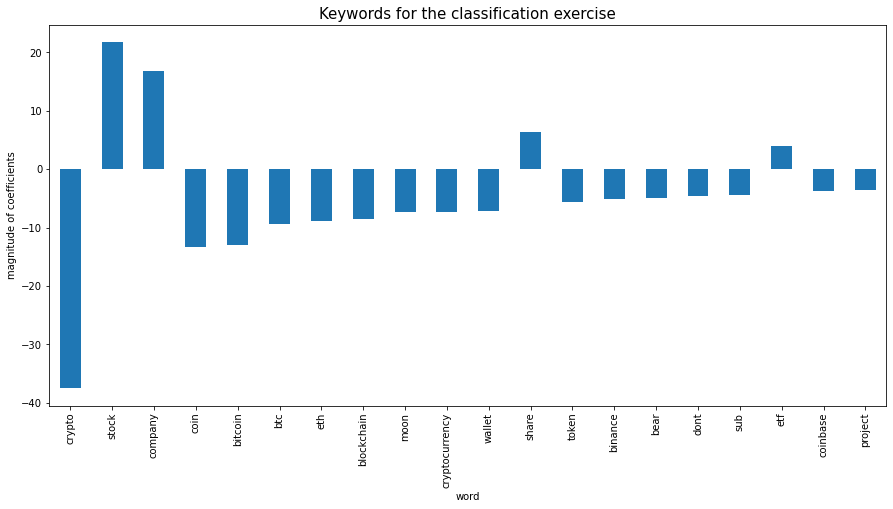

In [22]:
plt.title("Keywords for the classification exercise", fontsize=15)
coef_df.sort_values(by=["abs_coefficient"], ascending=False)["coefficient"].head(20).plot.bar(figsize=(15, 7))
plt.ylabel("magnitude of coefficients");

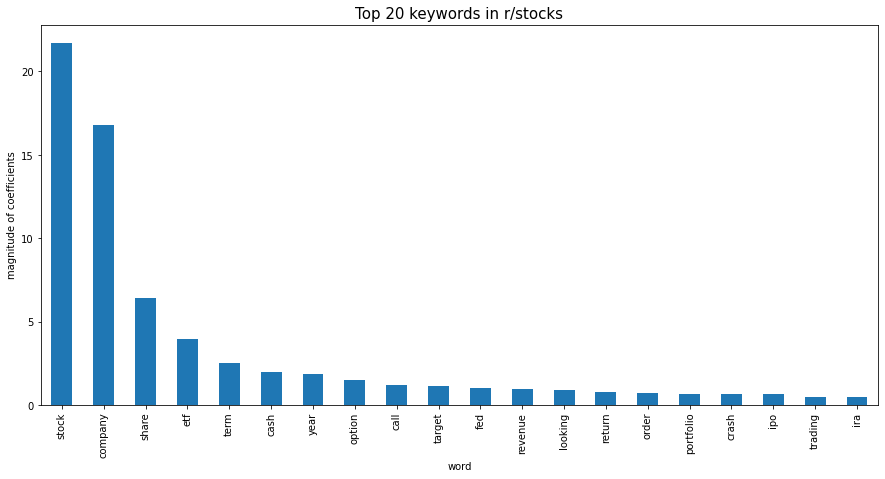

In [23]:
plt.title("Top 20 keywords in r/stocks", fontsize=15)
coef_df["coefficient"].sort_values(ascending=False).head(20).plot.bar(figsize=(15, 7))
plt.ylabel("magnitude of coefficients");

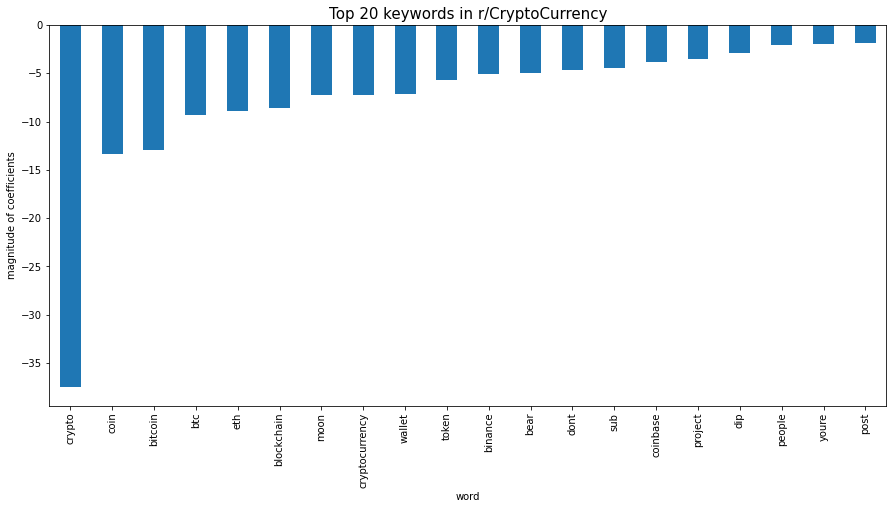

In [24]:
plt.title("Top 20 keywords in r/CryptoCurrency", fontsize=15)
coef_df["coefficient"].sort_values().head(20).plot.bar(figsize=(15, 7))
plt.ylabel("magnitude of coefficients");

## Recommendations

1) **Deploy the model for testing with live data** to optimise contents for relevance. Given the strong performance of the model (95% accuracy score and 98% sensitivity score), the team can stand to benefit from deploying the model for pilot testing on the reddit platform.  

2) **Flag posts classified as irrelevant for moderators' assessment**. There is a risk of incurring user frustrations if the subreddit members' relevant posts become removed as a result of the model misclassification. To minimize wrongful post(s) removal, we can instead use the model's recommendation to flag possibly misclassified posts for the moderators' consideration. This will help the moderators save time as they do not need to closely screen all the posts; they can just focus on reviewing the posts that the model has flagged. 

3) **Share keywords insights with the moderators**. This can help moderators set rules for content posting using the AutoModerator to ensure irrelevant topics will not be posted within the community. 

### Next Steps

In future, the team can extend on this project to:

- Collect data samples across a longer time (e.g. the past year) for training and model optimisation to pre-empt risk that the topics of discussion and keywords may change across different times of the year 
- Train and further optimise the model for production across more subreddit communities 
- Train the data using irrelevant posts from more than one source